mTSP - DS: MILP vs Matheuristic comparison

Imports:

In [1]:
from MTSP_DS_MILP_Solver import MTSP_DS_MILP_Solver
from MTSP_DS_Matheuristic_Solver import MTSP_DS_Matheuristic_Solver

from core.Location import rand_location
import numpy as np
import matplotlib.pyplot as plt
import concurrent.futures

Parameters:

m: number of drone stations
Dn: number of drones for each drone station
Kn: number of trucks

In [2]:
m = 2
Dn = 2
Kn = 2

n_trial = 4
num_of_nodes = [6,7,8,9,10,11,12]

In [3]:
def randomLocations(num_of_locations):
    locs = []
    for _ in range(num_of_locations):
        locs.append(rand_location())
    return locs

In [4]:
def get_milp_exec_time(number_of_nodes, nodes):
    milp_solver = MTSP_DS_MILP_Solver(number_of_nodes,m,Kn,Dn, custom_locations=nodes)
    milp_solver.solve()
    return milp_solver.getExecTime()

def get_matheuristic_exec_time(number_of_nodes, nodes):
    solver = MTSP_DS_Matheuristic_Solver(number_of_nodes,m,Kn,Dn, custom_locations=nodes)
    solver.solve()
    return solver.getExecTime()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-05


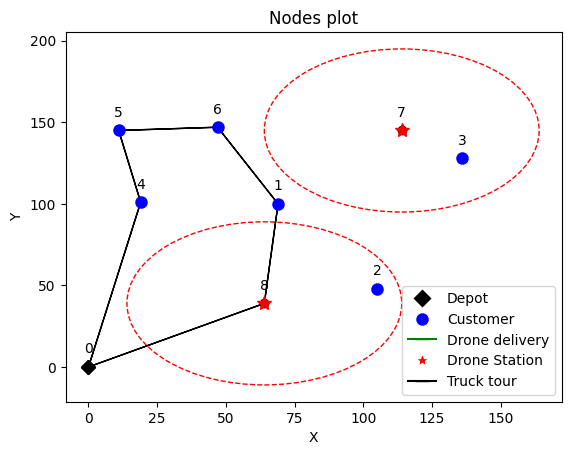

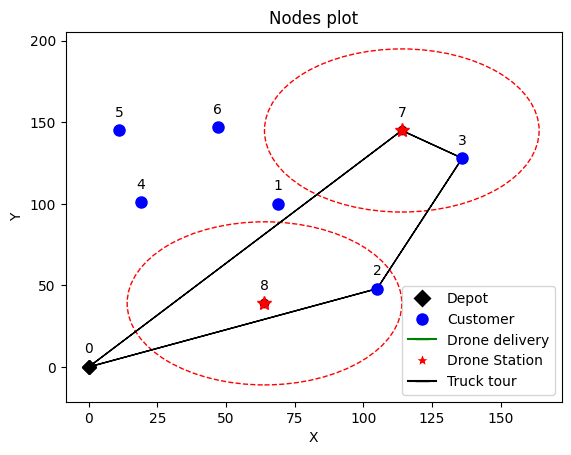

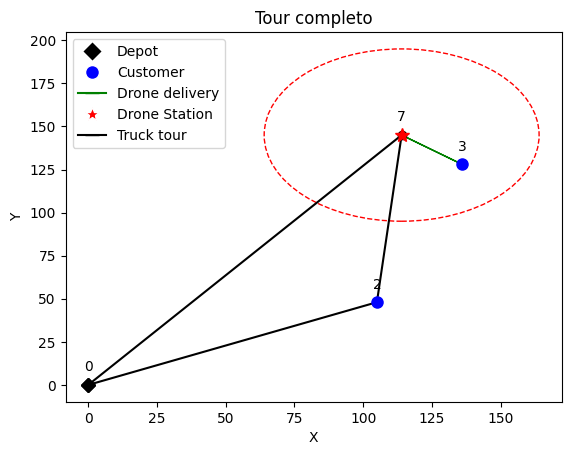

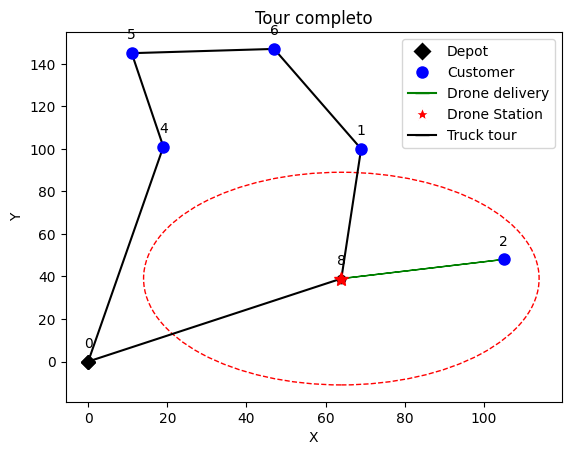

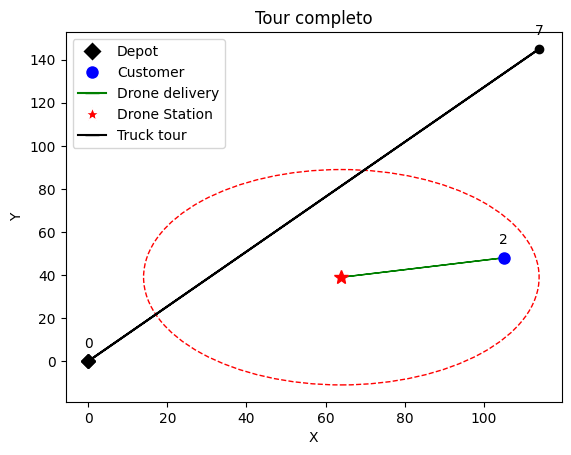

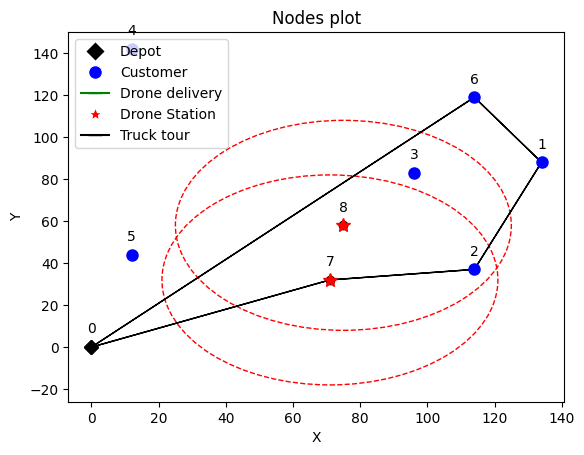

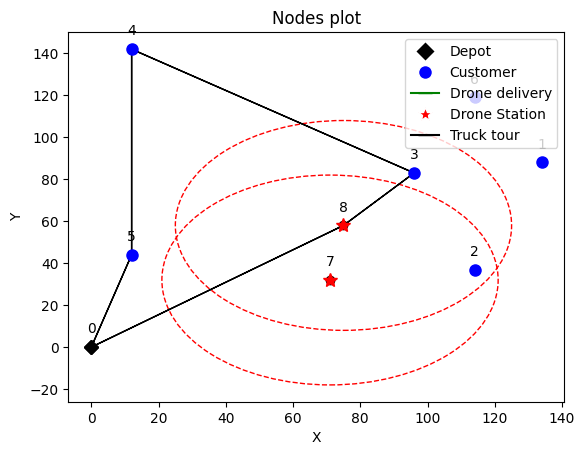

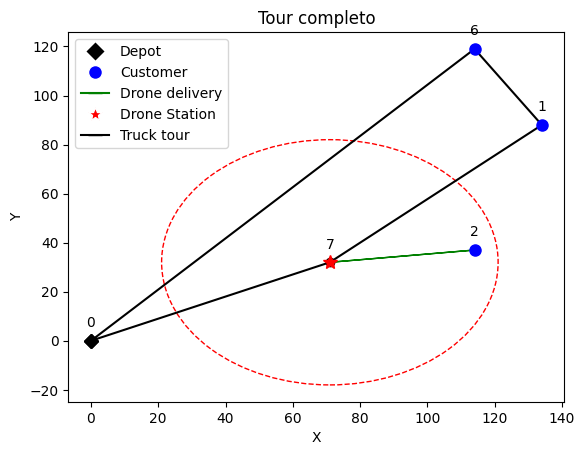

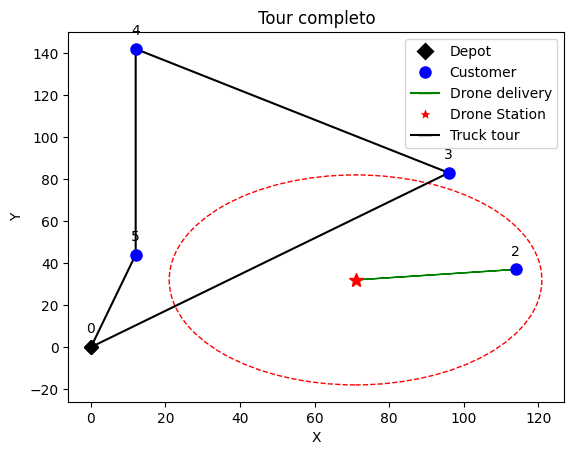

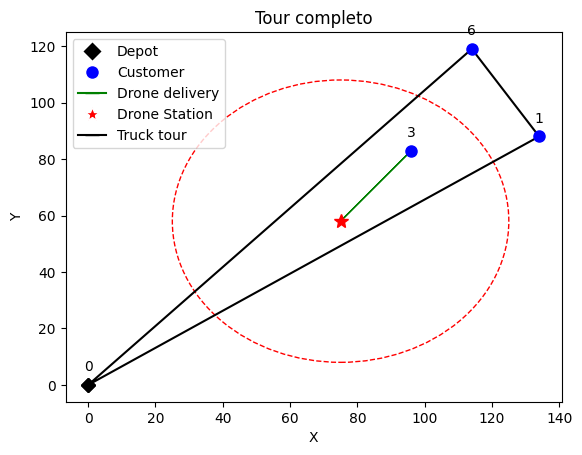

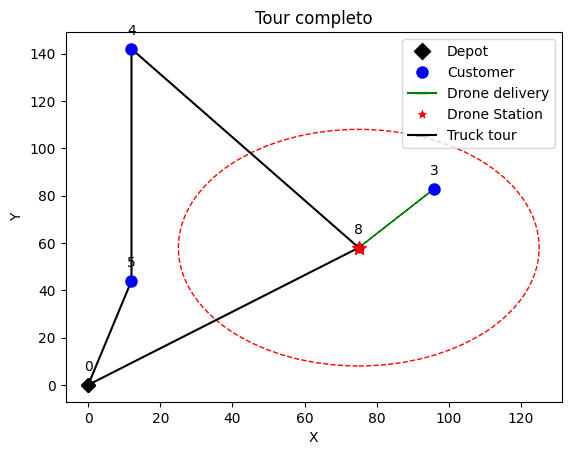

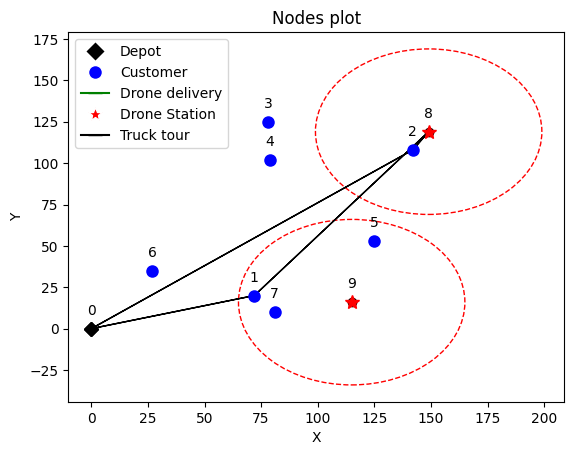

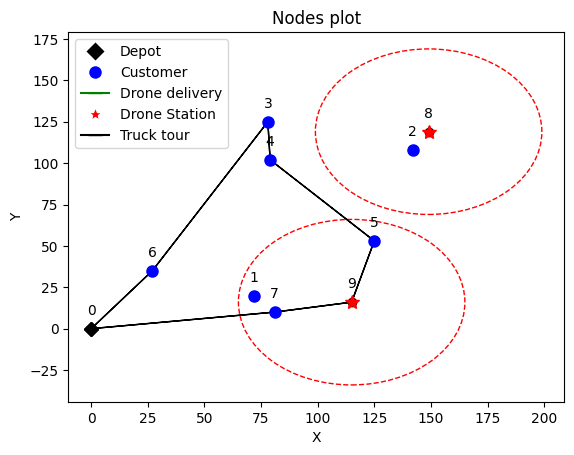

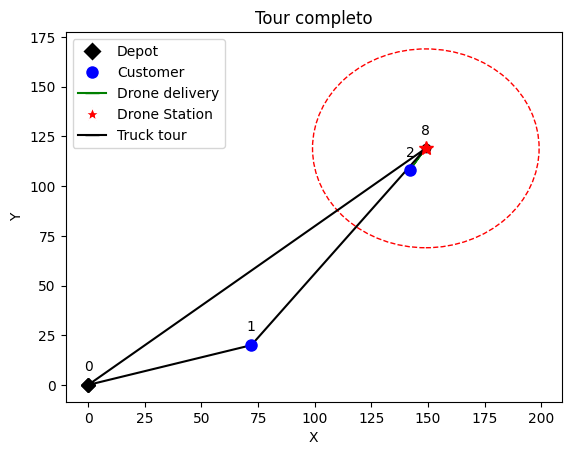

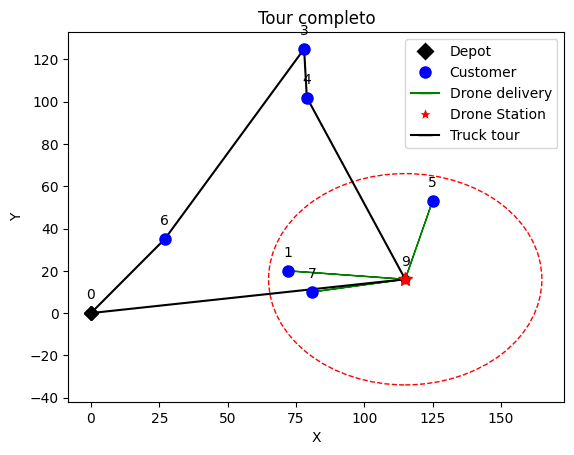

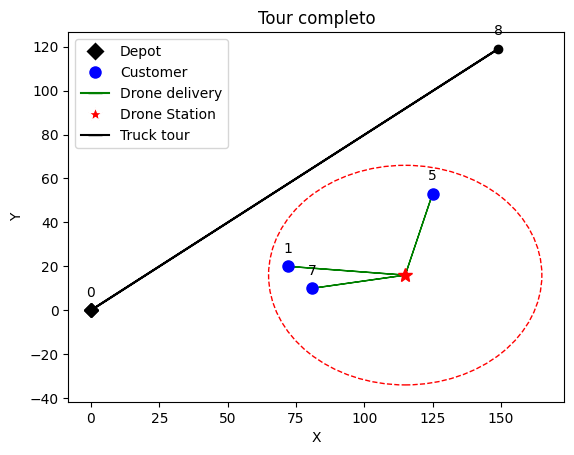

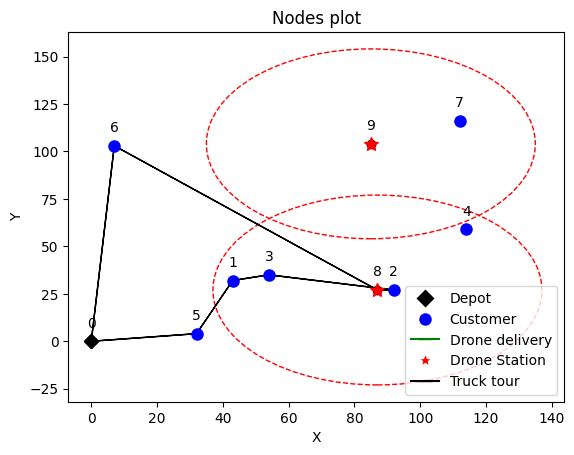

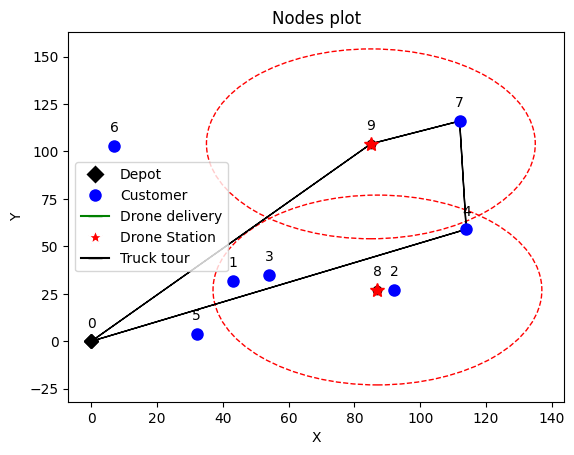

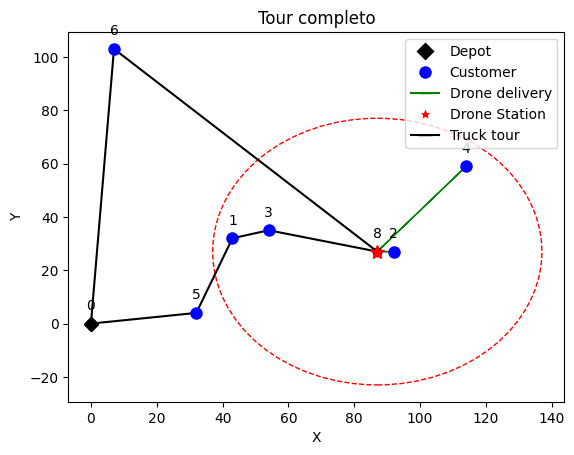

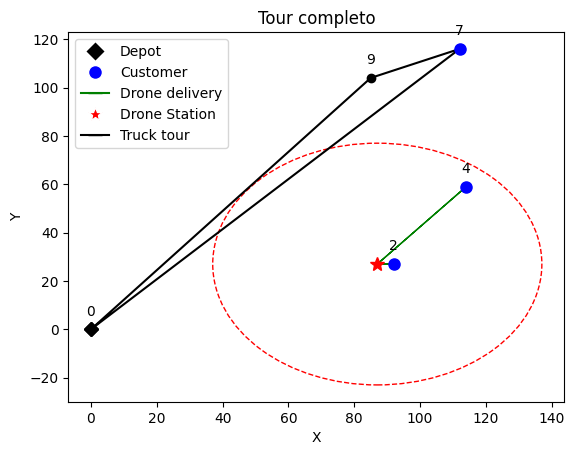

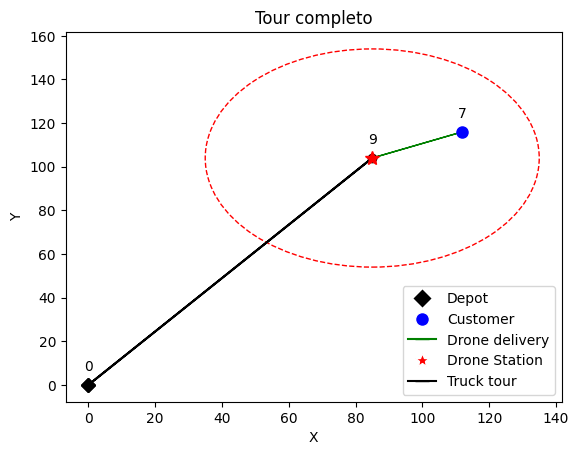

In [5]:
milp_average_exec_times = []
matheuristic_average_exec_times = []

def execute_with_timeout(func, nodes, locs, timeout=300):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        future = executor.submit(func, nodes, locs)
        try:
            result = future.result(timeout=timeout)
            return result
        except concurrent.futures.TimeoutError:
            raise TimeoutError(f"Function {func.__name__} exceeded timeout of {timeout} seconds")
        except Exception as er:
            raise er

for num_of_node in num_of_nodes:
    milp_exec_times = []
    math_exec_times = []
    for _ in range(n_trial):
        while True: 
            setup = randomLocations(num_of_node + m)
            try:
                milp_time = execute_with_timeout(get_milp_exec_time, num_of_node, setup)
                math_time = execute_with_timeout(get_matheuristic_exec_time, num_of_node, setup)
                milp_exec_times.append(milp_time)
                math_exec_times.append(math_time)
                break  # Uscire dal ciclo while se entrambe le esecuzioni sono riuscite
            except (Exception, TimeoutError) as e:
                print(f"Errore durante l'esecuzione: {e}. Ritentando con un nuovo setup.")
                continue  # new setup
    milp_average_exec_times.append(np.mean(milp_exec_times))
    matheuristic_average_exec_times.append(np.mean(math_exec_times))  

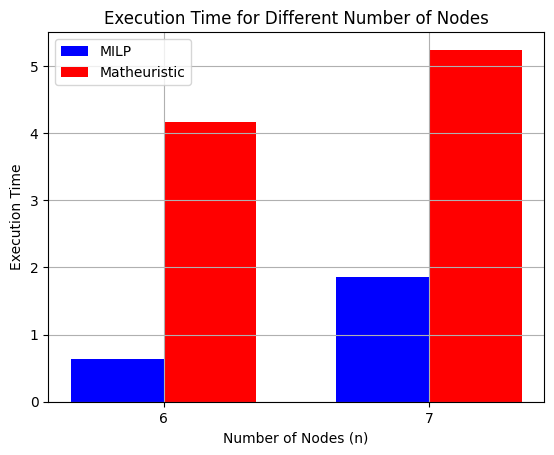

In [6]:
def plot_exec_times(nodes, milp_exec_time, matheuristic_exec_times):
    width = 0.35  
    x = np.arange(len(nodes))

    fig, ax = plt.subplots()
    ax.bar(x - width/2, milp_exec_time, width, label='MILP', color='blue')
    ax.bar(x + width/2, matheuristic_exec_times, width, label='Matheuristic', color='red')
    
    ax.set_xlabel('Number of Nodes (n)')
    ax.set_ylabel('Execution Time')
    ax.set_title('Execution Time for Different Number of Nodes')
    ax.set_xticks(x)
    ax.set_xticklabels(num_of_nodes)
    ax.legend()
    ax.grid(True)
    
    plt.show()

plot_exec_times(num_of_nodes, milp_average_exec_times, matheuristic_average_exec_times)